# 개, 고양이 분류 - CNN v2
- 부분 데이터 : 훈련 dogs(1000), cats(1000), 테스트 dogs(1000), cats(1000)
- 이미지 센터링 처리 안함

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-05-24 06:33:26--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   314MB/s    in 0.2s    

2022-05-24 06:33:27 (314 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
!unzip cats_and_dogs_filtered.zip > /dev/null

- 데이터 탐색

In [4]:
# 이미지를 축소/확대 및 센터링해서 이미지를 반환하는 함수
IMAGE_SIZE =150

(<matplotlib.image.AxesImage at 0x7fde17cb98d0>,
 Text(0.5, 1.0, '(287, 431)'),
 (-0.5, 430.5, 286.5, -0.5))

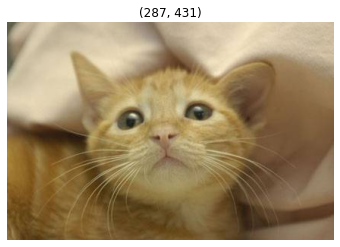

In [5]:
import cv2
fname = "cats_and_dogs_filtered/train/cats/cat.475.jpg"
img = cv2.imread(fname)[:,:,::-1]
plt.imshow(img), plt.title(img.shape[:-1]), plt.axis("off")

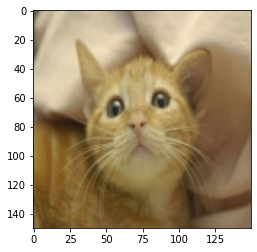

In [6]:
plt.imshow(cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA))

In [7]:
h, w , _ = img.shape
h, w

(287, 431)

In [8]:
if h > w:
    width, height = IMAGE_SIZE, (h * IMAGE_SIZE) // w
else :
    width, height = (w * IMAGE_SIZE) // h, IMAGE_SIZE


In [9]:
new_img = cv2.resize(img, dsize=(width,height), interpolation = cv2.INTER_AREA)
new_img.shape

(150, 225, 3)

In [10]:
diff = abs(width - height) // 2

In [11]:
if h > w:
    final_img = new_img[diff:diff+IMAGE_SIZE, :]
else :
    final_img = new_img[:, diff:diff+IMAGE_SIZE]

(<matplotlib.image.AxesImage at 0x7fde16724450>,
 Text(0.5, 1.0, '(150, 150)'),
 (-0.5, 149.5, 149.5, -0.5))

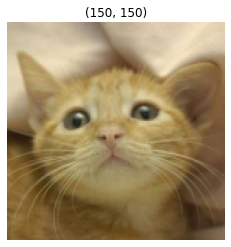

In [12]:
plt.imshow(final_img), plt.title(final_img.shape[:-1]), plt.axis("off")

In [13]:
from PIL import Image
def center_image(img, src_format="Numpy", dst_format = "Numpy"):
    if src_format == "Numpy":
        h, w= img.shape[:-1]
    else:       # Pillow
        h, w = np.array(img).shape[:-1]
    if h > w:
        width, height = IMAGE_SIZE, (h * IMAGE_SIZE) // w
    else :
        width, height = (w * IMAGE_SIZE) // h, IMAGE_SIZE

    interpolation = cv2.INTER_AREA if h + w > 300 else cv2.INTER_CUBIC
    new_img = cv2.resize(img, dsize=(width,height), interpolation = interpolation)
    diff = abs(width - height) // 2 
    if h > w:
        final_img = new_img[diff:diff+IMAGE_SIZE, :]
    else :
        final_img = new_img[:, diff:diff+IMAGE_SIZE]
    return final_img if dst_format == "OpenCV" else Image.fromarray(final_img)

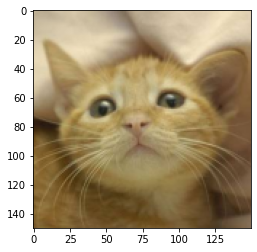

In [14]:
img = cv2.imread(fname)[:,:,::-1]
plt.imshow(center_image(img));

- 파일에서 읽어서 센터 이미지로 변환해서 저장

In [15]:
CENTER_DIR = 'cats_and_dogs_centered'
train_dir = f'{CENTER_DIR}/train'
validation_dir = f'{CENTER_DIR}/validation'
train_cats_dir = f'{CENTER_DIR}/train/cats'
train_dogs_dir = f'{CENTER_DIR}/train/dogs'
validation_cats_dir = f'{CENTER_DIR}/validation/cats'
validation_dogs_dir = f'{CENTER_DIR}/validation/dogs'

In [16]:
import os
if not os.path.exists(CENTER_DIR):
    os.mkdir(CENTER_DIR)
for dir in [train_dir, validation_dir, train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir]:
    os.mkdir(dir)

In [17]:
old_train_cats_dir = 'cats_and_dogs_filtered/train/cats'
old_train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
old_validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
old_validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [18]:
# cats_and_dogs_filtered -> image 축소/확대후 centering -> cats_and_dogs_centered
from glob import glob

for src_dir in [old_train_cats_dir, old_train_dogs_dir, old_validation_cats_dir, old_validation_dogs_dir]:
    dst_dir = src_dir.replace("filtered", "centered")
    for fname in glob(f"{src_dir}/*.jpg"):
        dst_fname = fname.split("/")[-1]
        src_img = cv2.imread(fname)[:,:,::-1]
        dst_img = center_image(src_img, src_format = "OpenCV", dst_format = "Pillow")
        dst_img.save(f"{dst_dir}/{dst_fname}")

In [19]:
import os 
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

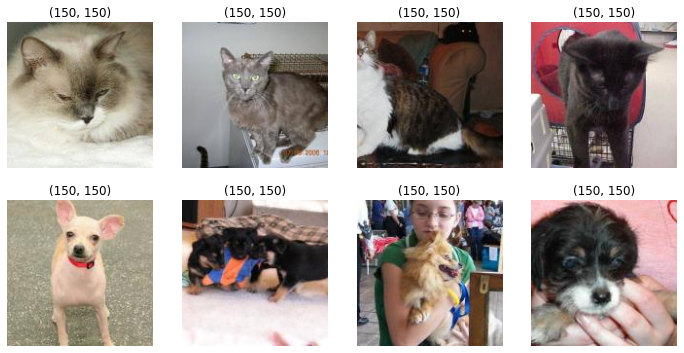

In [20]:
plt.figure(figsize = (12,6))
for i in range(1, 5):
    plt.subplot(2,4, i)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis("off"), plt.title(cat.shape[:-1])
    plt.subplot(2,4, i+4)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis("off"), plt.title(dog.shape[:-1])

In [21]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [22]:
model = Sequential([
        Conv2D(16, (3,3), input_shape = (150,150,3), activation = "relu"),
        MaxPooling2D(),
        Conv2D(32, (3,3), activation = "relu"),
        MaxPooling2D(),
        Conv2D(64, (3,3), activation = "relu"),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation = "relu"),
        # Dropout(0.25),
        Dense(1, activation = "sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [23]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-8),
              loss="binary_crossentropy", metrics = ["accuracy"])

In [24]:
model_path = "best-cats-and-dogs-cnn-v2.h5"
mc = ModelCheckpoint(model_path, save_best_only=True, verbose = 1)
es = EarlyStopping(patience = 10)

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [26]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size = 20, class_mode = "binary", target_size = (150, 150)
)
test_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size = 20, class_mode = "binary", target_size = (150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [27]:
hist = model.fit(
    train_generator, validation_data = test_generator,
    epochs = 100, callbacks=[mc,es], 
    steps_per_epoch = 80, validation_steps = 50
)

Epoch 1/100
78/80 [============================>.] - ETA: 0s - loss: 0.7928 - accuracy: 0.5622
Epoch 1: val_loss improved from inf to 0.62978, saving model to best-cats-and-dogs-cnn-v2.h5
80/80 [==============================] - 16s 39ms/step - loss: 0.7890 - accuracy: 0.5625 - val_loss: 0.6298 - val_accuracy: 0.6410
Epoch 2/100
78/80 [============================>.] - ETA: 0s - loss: 0.6369 - accuracy: 0.6538
Epoch 2: val_loss improved from 0.62978 to 0.61406, saving model to best-cats-and-dogs-cnn-v2.h5
80/80 [==============================] - 3s 38ms/step - loss: 0.6364 - accuracy: 0.6569 - val_loss: 0.6141 - val_accuracy: 0.6600
Epoch 3/100
79/80 [============================>.] - ETA: 0s - loss: 0.6001 - accuracy: 0.6975
Epoch 3: val_loss improved from 0.61406 to 0.61155, saving model to best-cats-and-dogs-cnn-v2.h5
80/80 [==============================] - 3s 38ms/step - loss: 0.5984 - accuracy: 0.6969 - val_loss: 0.6115 - val_accuracy: 0.6780
Epoch 4/100
79/80 [==================

In [28]:
from google.colab import files 
up = files.upload()

Saving 개.jpg to 개.jpg
Saving 개1.jfif to 개1.jfif
Saving 개2.jpg to 개2.jpg
Saving 고양이.jpg to 고양이.jpg
Saving 고양이1.jpg to 고양이1.jpg
Saving 고양이2.jfif to 고양이2.jfif


In [30]:
best_model = load_model("best-cats-and-dogs-cnn-v2.h5")


In [31]:
for fname in up.keys():
    img = cv2.imread(fname)[:,:,::-1]
    if sum(img.shape[:-1]) > 300:
        img = cv2.resize(img, dsize = (150,150), interpolation = cv2.INTER_AREA)
    else:
        img = cv2.resize(img, dsize = (150,150), interpolation = cv2.INTER_CUBIC)
    classes = best_model.predict(img.reshape(1,150,150,3))
    print(f"{classes[0,0]:.4f} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")

1.0000 개.jpg is a dog
1.0000 개1.jfif is a dog
1.0000 개2.jpg is a dog
1.0000 고양이.jpg is a dog
0.0000 고양이1.jpg is a cat
0.0000 고양이2.jfif is a cat
